<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

## Introduction to `pandas` Grouping

_Authors: Kiefer Katovich (SF), Dave Yerrington (SF), Mario Carrillo (SF)_

---

### Learning Objectives
*After this lesson, you will be able to:*
- Identify the situations in which **grouping** is useful.
- Explain and use the **`.groupby()`** function in `pandas`.
- Demonstrate aggregation and plotting methods by groups in `pandas`.

### Lesson Guide

- [Overview of Multi-Dimensional Data Analysis](#overview)
- [Analyzing Data by Group: Examples](#grouping_examples)
- [Exploring the Titanic Data Set with Grouping](#load_titanic)
- [Introducing `pandas` `.groupby()` Function](#groupby)
- [Grouping by Multiple Variables](#groupby_multiple)
- [Applying Basic Functions to Groups](#basic_functions)
- [Removing the Hierarchical Index](#removing_hierarchical)
- [Applying Custom Functions with `.apply()`](#custom_functions)
- [Plotting Basic Histograms with Groups](#basic_plotting)
- [Grouped Histograms with `pandas`](#grouped_hists)
- [Independent Practice](#independent_practice)


<a id='overview'></a>

### Overview of Multi-Dimensional Data Analysis

---

Multi-dimensional data analysis allows you to:

- Describe segments of your data based on unique values.
- Understand characteristics of your data.
   - Calculate summary statistics across subsets.
   - Discover patterns that exist in some subsets but not others.
- Find duplicate values or redundant data.
- Apply aggregate functions to subsets.


<a id='grouping_examples'></a>

### Analyzing Data by Group: Examples

---

Scenarios include determining the: 

 - Sum of crimes by time of day in San Francisco (morning, afternoon, night).
 - Count number of people with the same last name.
 - Median number of multi-unit buildings in a region.
 - Popularity of movie genres by region.
 - Customer segments based on age, buying habits, interests, and behavior.
 
 You can also apply the "GROUP BY" clause in a database query using SQL.

#### Subset Aggregation:

This chart stratifies a single variable, "industry," **counting** job openings within a specific category.

![](http://www.rasmussen.edu/images/blogs/1360270834-402_Graphs_JobOpeningsByIndustry.jpg)

#### Hierarchical Aggregation

This chart aggregates first by a top-level group, "industry," and then by a secondary group, "date," within each industry.

![](http://junkcharts.typepad.com/.a/6a00d8341e992c53ef0192acc65090970d-pi)

<a id='load_titanic'></a>

### Exploring the Titanic Data Set with Grouping

---

To explore the power of grouping with `pandas`, we will be using [the famous Titanic data set](https://www.kaggle.com/c/titanic), which can be downloaded from Kaggle. Here's the competition description:

>The sinking of the RMS Titanic is one of the most infamous shipwrecks in history. On April 15, 1912, during her maiden voyage, the Titanic sank after colliding with an iceberg, killing 1,502 out of 2,224 passengers and crew. This sensational tragedy shocked the international community and led to better safety regulations for ships.

>One of the reasons that the shipwreck led to such loss of life was that there were not enough lifeboats for the passengers and crew. Although there was some element of luck involved in surviving the sinking, some groups of people were more likely to survive than others, such as women, children, and the upper class.

Although we will not be modeling survival rates in this lesson, there are interesting patterns to be found just by exploring descriptive statistics in cross-sections of the data.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('whitegrid')

%matplotlib inline
%config InlineBackend.figure_format ='retina'

**Load the data into `pandas`.**

In [111]:
path_to_file = './datasets/titanic_clean.csv'
df = pd.read_csv(path_to_file)
df.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S


The data contains a variety of information about the passengers present at the sinking of the Titanic.

**Describe the data in the columns with summary statistics.**

In [4]:
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000
mean,448.589888,0.404494,2.240169,29.642093,0.514045,0.432584,34.567251
std,258.683191,0.491139,0.836854,14.492933,0.930692,0.854181,52.938648
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,222.750000,0.000000,1.000000,20.000000,0.000000,0.000000,8.050000
50%,445.000000,0.000000,2.000000,28.000000,0.000000,0.000000,15.645850
75%,677.250000,1.000000,3.000000,38.000000,1.000000,1.000000,33.000000
max,891.000000,1.000000,3.000000,80.000000,5.000000,6.000000,512.329200


<a id='groupby'></a>

### Introducing `pandas`' `.groupby()` Function

---

The built-in `.groupby()` function for DataFrames is one of the most useful tools in `pandas`. As the name implies, `.groupby()` will group your data set by one or more user-specified column names.

**Using `.groupby()`, create a grouped DataFrame in which the Titanic data set is grouped by "Pclass."**

In [12]:
df.groupby('Pclass')

**Print out the type of the grouped DataFrame.**

In [11]:
type(df.groupby('Pclass'))

pandas.core.groupby.DataFrameGroupBy

Instead of a `DataFrame` object, we now have a `DataFrameGroupBy` object. This operates somewhat differently than the DataFrames we're used to, as we'll soon see.

**Try pulling out the first group from the grouped DataFrame with index 0.**

In [13]:
pclassgrp = df.groupby('Pclass')
pclassgrp[0]

KeyError: 'Column not found: 0'

Grouped DataFrames operate differently than Python lists. You can't pull out different groups with indexers. Despite this, grouped DataFrame objects **are** iterable! You can step through them using a for loop, for example.

In our grouped DataFrame, each element will be a tuple containing the "Pclass" group as its first element and the subset of the original Titanic DataFrame for that "Pclass" as its second element.

**Write a for loop to iterate through the grouped DataFrame, printing out the "PClass" and the header of the subset each time.**

In [203]:
len(pclassgrp)
for i in pclassgrp:
    print i[0]
    print i[1].head(3)

1
   PassengerId  Survived  Pclass  \
1            2         1       1   
3            4         1       1   
5            7         0       1   

                                                Name     Sex   Age  SibSp  \
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
5                            McCarthy, Mr. Timothy J    male  54.0      0   

   Parch     Fare Embarked  
1      0  71.2833        C  
3      0  53.1000        S  
5      0  51.8625        S  
2
    PassengerId  Survived  Pclass                                 Name  \
8            10         1       2  Nasser, Mrs. Nicholas (Adele Achem)   
14           16         1       2     Hewlett, Mrs. (Mary D Kingcome)    
17           21         0       2                 Fynney, Mr. Joseph J   

       Sex   Age  SibSp  Parch     Fare Embarked  
8   female  14.0      1      0  30.0708        C  
14  female  55.0      0    

<a id='groupby_multiple'></a>

### Grouping by Multiple Variables

---

Grouping by more than one column is simple; the `.groupby()` function can accept a list of column names to group by. When you group by more than one column, each subset of the data will correspond to one distinct combination of the grouping columns.

**Create a grouped DataFrame by grouping the Titanic data by "Pclass" and "Survived."**

In [15]:
doublegrp = df.groupby(['Pclass','Survived'])

**Print out the length of this grouped DataFrame.**

It is the same length as the unique combinations of "Pclass" and "Survived:" three Pclasses by two survival values.

In [16]:
len(doublegrp)

6

<a id='basic_functions'></a>

### Applying Basic Functions to Groups

---

`pandas` makes it easy to apply basic statistical functions to grouped data with built-in functions. For example, assume you have a grouped DataFrame, `grouped`:

```python
print grouped.mean()
print grouped.median()
print grouped.count()
print grouped.max()
```

We can calculate the mean, median, count, and max of the columns by group. 

**Try out these built-in functions on the grouped data you made above.**

In [32]:
df.groupby('Pclass').mean()

,PassengerId,Survived,Age,SibSp,Parch,Fare
Pclass,,,,,,
1,464.157609,0.652174,38.105543,0.456522,0.413043,88.048121
2,447.156069,0.479769,29.877630,0.427746,0.404624,21.471556
3,441.219718,0.239437,25.140620,0.585915,0.456338,13.229435


In [25]:
df.groupby('Pclass').count()

,PassengerId,Survived,Name,Sex,Age,SibSp,Parch,Fare,Embarked
Pclass,,,,,,,,,
1,184,184,184,184,184,184,184,184,184
2,173,173,173,173,173,173,173,173,173
3,355,355,355,355,355,355,355,355,355


In [26]:
df.groupby('Pclass').size()

Pclass
1    184
2    173
3    355
dtype: int64

You can also operate on single columns or subsets of columns across grouped DataFrames using the indexing syntax for standard DataFrames.

**Find the percent of passengers who survived, grouped by where they embarked.**

In [68]:
dfgrp = df.groupby(['Embarked']).sum()
print dfgrp['Survived'], df.groupby('Embarked').size()

Embarked
C     79
Q      8
S    201
Name: Survived, dtype: int64 Embarked
C    130
Q     28
S    554
dtype: int64


In [69]:
(dfgrp['Survived']/df.groupby('Embarked').size())*100

Embarked
C    60.769231
Q    28.571429
S    36.281588
dtype: float64

**Find the average fare and age, grouped by the location embarked as well as the class.**

In [74]:
df.groupby(['Embarked','Pclass']).mean()[['Fare','Age']]

Fare        Age
Embarked Pclass                       
C        1       108.246399  38.027027
         2        26.811947  22.766667
         3        11.369927  20.741951
Q        1        90.000000  38.500000
         2        12.350000  43.500000
         3        12.780904  25.937500
S        1        74.172415  38.152037
         2        21.075000  30.386731
         3        13.529451  25.696552

<a id='removing_hierarchical'></a>

### Removing the Hierarchical Index

---

By default, `pandas` will give you back your groups in a hierarchical index format. If this is not what you prefer, you can use the `.reset_index()` function to take your row labels and convert them into columns.

**Remove the hierarchical index for the average fare and age data set you just created, converting "Embarked" and "Pclass" to columns.**

In [75]:
df.groupby(['Embarked','Pclass']).mean()[['Fare','Age']].reset_index()

,Embarked,Pclass,Fare,Age
0,C,1,108.246399,38.027027
1,C,2,26.811947,22.766667
2,C,3,11.369927,20.741951
3,Q,1,90.000000,38.500000
4,Q,2,12.350000,43.500000
5,Q,3,12.780904,25.937500
6,S,1,74.172415,38.152037
7,S,2,21.075000,30.386731
8,S,3,13.529451,25.696552


<a id='custom_functions'></a>

### Applying Custom Functions with `.apply()`

---

While `pandas` does contain a variety of useful, built-in summary functions, you'll often need to apply a custom function to the data in your groups. 

The `.apply()` function takes a function as an argument and applies it to the subsets of data in your DataFrame groups.

**See what happens when you replace the built-in `.mean()` function with `.apply(np.mean)` for the question above.**

In [80]:
df.groupby(['Embarked','Pclass']).apply(np.mean)

PassengerId  Survived  Pclass        Age     SibSp     Parch  \
Embarked Pclass                                                                 
C        1        436.837838  0.716216     1.0  38.027027  0.391892  0.364865   
         2        454.933333  0.533333     2.0  22.766667  0.666667  0.600000   
         3        482.487805  0.439024     3.0  20.741951  0.390244  0.439024   
Q        1        329.500000  0.500000     1.0  38.500000  1.500000  0.000000   
         2        475.000000  0.500000     2.0  43.500000  0.000000  0.000000   
         3        416.000000  0.250000     3.0  25.937500  0.750000  0.458333   
S        1        485.370370  0.611111     1.0  38.152037  0.481481  0.453704   
         2        446.051282  0.474359     2.0  30.386731  0.410256  0.391026   
         3        437.472414  0.210345     3.0  25.696552  0.600000  0.458621   

                       Fare  
Embarked Pclass              
C        1       108.246399  
         2        26.811947  
         3        11.369927  
Q        1        90.000000  
         2        12.350000  
         3        12.780904  
S        1        74.172415  
         2        21.075000  
         3        13.529451

Say we want to determine the mean of fare and age per "Embarked" and "Pclass," but we also want the numbers to be rounded. One way to do this would be to round the columns after we apply the mean function as we did above. 

Another way would be to write a custom function to pass into `.apply()`. *The function passed to `.apply()` will run on all of the subsets of data.*

**Write a function that will take the mean of columns in a data set and round the values.**

In [179]:
def round2(col):
    return np.round(np.mean(col),0)

In [180]:
round2(df['Fare'])

35.0

In [109]:
df.groupby(['Embarked','Pclass']).apply(round2)

PassengerId  Survived  Pclass    Age  SibSp  Parch    Fare
Embarked Pclass                                                            
C        1            436.84      0.72     1.0  38.03   0.39   0.36  108.25
         2            454.93      0.53     2.0  22.77   0.67   0.60   26.81
         3            482.49      0.44     3.0  20.74   0.39   0.44   11.37
Q        1            329.50      0.50     1.0  38.50   1.50   0.00   90.00
         2            475.00      0.50     2.0  43.50   0.00   0.00   12.35
         3            416.00      0.25     3.0  25.94   0.75   0.46   12.78
S        1            485.37      0.61     1.0  38.15   0.48   0.45   74.17
         2            446.05      0.47     2.0  30.39   0.41   0.39   21.08
         3            437.47      0.21     3.0  25.70   0.60   0.46   13.53

In [96]:
df.groupby(['Embarked','Pclass']).apply(lambda x: np.round(np.mean(x),2))

PassengerId  Survived  Pclass    Age  SibSp  Parch    Fare
Embarked Pclass                                                            
C        1            436.84      0.72     1.0  38.03   0.39   0.36  108.25
         2            454.93      0.53     2.0  22.77   0.67   0.60   26.81
         3            482.49      0.44     3.0  20.74   0.39   0.44   11.37
Q        1            329.50      0.50     1.0  38.50   1.50   0.00   90.00
         2            475.00      0.50     2.0  43.50   0.00   0.00   12.35
         3            416.00      0.25     3.0  25.94   0.75   0.46   12.78
S        1            485.37      0.61     1.0  38.15   0.48   0.45   74.17
         2            446.05      0.47     2.0  30.39   0.41   0.39   21.08
         3            437.47      0.21     3.0  25.70   0.60   0.46   13.53

**Apply your custom function to the grouped data.**

Functions that can be applied to a DataFrame and return a DataFrame can also be applied to *groups* of DataFrames.

**For example, write a function that will return the subset of the Titanic data set with the top five paying female passsengers.**


In [215]:
def topfemale(df):
    return df[df['Sex']=='female'].sort_values('Fare', ascending=False).head(5)

**Group the Titanic data by "Survived" and apply your function to extract the top paying females.**

In [216]:
df.groupby('Survived').apply(topfemale)

PassengerId  Survived  Pclass  \
Survived                                      
0        395          499         0       1   
         239          298         0       1   
         535          679         0       3   
         53            72         0       3   
         504          639         0       3   
1        207          259         1       1   
         273          342         1       1   
         66            89         1       1   
         247          312         1       1   
         588          743         1       1   

                                                         Name     Sex   Age  \
Survived                                                                      
0        395  Allison, Mrs. Hudson J C (Bessie Waldo Daniels)  female  25.0   
         239                     Allison, Miss. Helen Loraine  female   2.0   
         535          Goodwin, Mrs. Frederick (Augusta Tyler)  female  43.0   
         53                        Goodwin, Miss. Lillian Amy  female  16.0   
         504           Panula, Mrs. Juha (Maria Emilia Ojala)  female  41.0   
1        207                                 Ward, Miss. Anna  female  35.0   
         273                   Fortune, Miss. Alice Elizabeth  female  24.0   
         66                        Fortune, Miss. Mabel Helen  female  23.0   
         247                       Ryerson, Miss. Emily Borie  female  18.0   
         588            Ryerson, Miss. Susan Parker "Suzette"  female  21.0   

              SibSp  Parch      Fare Embarked  
Survived                                       
0        395      1      2  151.5500        S  
         239      1      2  151.5500        S  
         535      1      6   46.9000        S  
         53       5      2   46.9000        S  
         504      0      5   39.6875        S  
1        207      0      0  512.3292        C  
         273      3      2  263.0000        S  
         66       3      2  263.0000        S  
         247      2      2  262.3750        C  
         588      2      2  262.3750        C

<a id='basic_plotting'></a>

### Plotting Basic Histograms with Groups

---

We can leverage the power of `pandas` even more by mixing its plotting capabilities with its grouping capabilities.

**First, find the number of passengers per "PClass" by using `.groupby()` and `.size()`.**

In [154]:
df.groupby('Pclass').size()

Pclass
1    184
2    173
3    355
dtype: int64

Here we have a Series object with the counts of the passengers-per-class group. It's easy to create a histogram of these counts by appending `.plot(kind="bar", color="g", width=0.85)`.

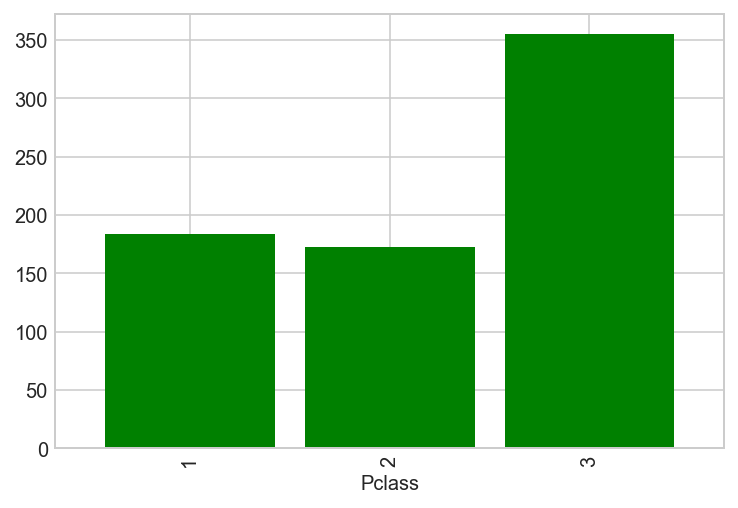

In [160]:
df.groupby('Pclass').size().plot(kind='bar', color='g', width=0.85)

**Plot the average fare per sex and class as a histogram.**

In [182]:
df.groupby(['Sex','Pclass']).mean()['Fare']

Sex     Pclass
female  1         108.619680
        2          21.951070
        3          15.875369
male    1          71.142781
        2          21.113131
        3          12.162695
Name: Fare, dtype: float64

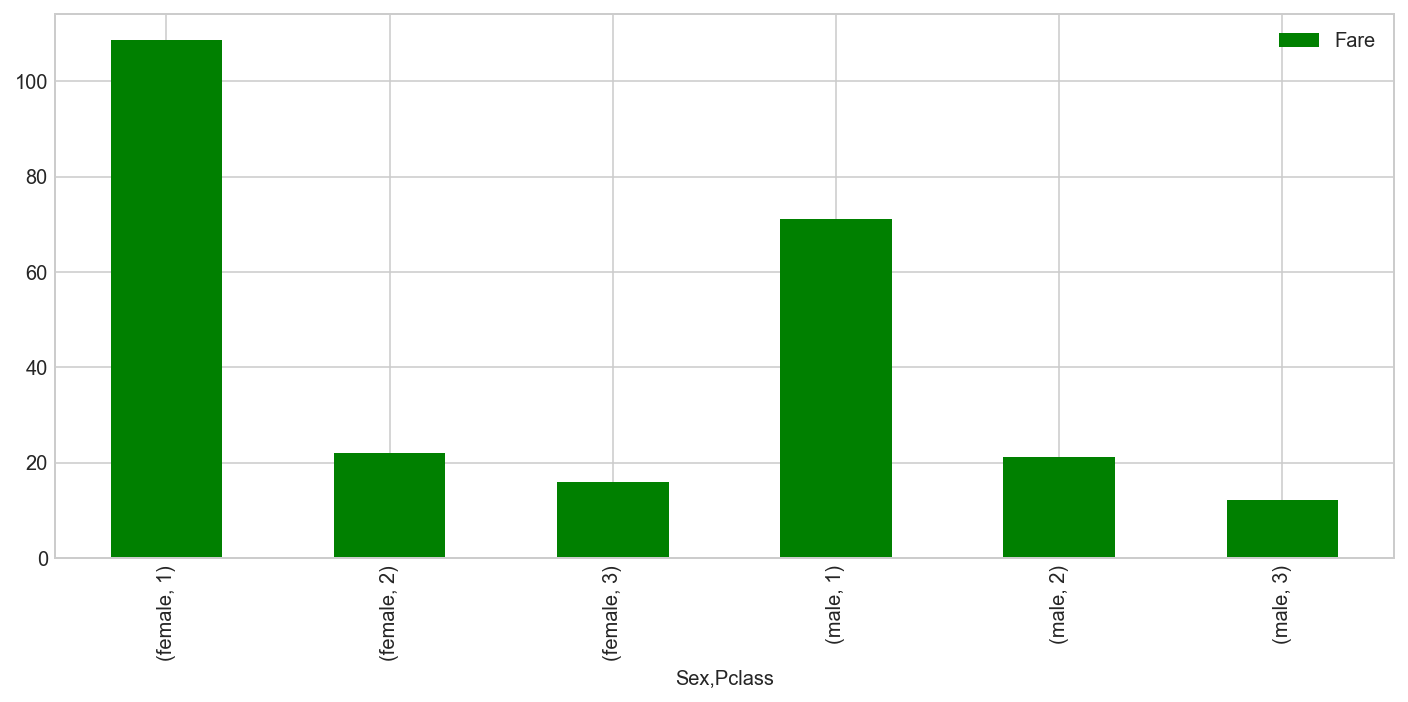

In [192]:
df.groupby(['Sex','Pclass']).mean()['Fare'].plot(kind='bar', color='g', figsize=(12,5))
plt.legend(loc=1)

<a id='grouped_hists'></a>

### Grouped Histograms with `pandas`

---

In the chart we just made, each bar represents a distinct combination of our groups in `.groupby()`. This is fine, but it would be a more visually appealing and informative chart if we represented each group with a different color and made a grouped bar chart.

**Calculate the mean of fare by "Pclass" and "Sex" using `.groupby()`, assign it to a variable, and print it out.**

In [196]:
avgfare = df.groupby(['Pclass','Sex']).mean()['Fare']
print avgfare

Pclass  Sex   
1       female    108.619680
        male       71.142781
2       female     21.951070
        male       21.113131
3       female     15.875369
        male       12.162695
Name: Fare, dtype: float64


There is another built-in function for `pandas` objects called `.unstack()`. When we have a hierarchical index like we do above with "Pclass" as the broader category and "Sex" as the subcategory, the `.unstack()` command will attempt to move the subcategory from index to column representation.

This is a way to move from a "long" to a "wide" column format.

**Use the `.unstack()` function on your mean fare variable.**

In [197]:
avgfare.unstack()

Sex,female,male
Pclass,,
1,108.619680,71.142781
2,21.951070,21.113131
3,15.875369,12.162695


**Now, use the plot function on the unstacked data to create a bar chart.**

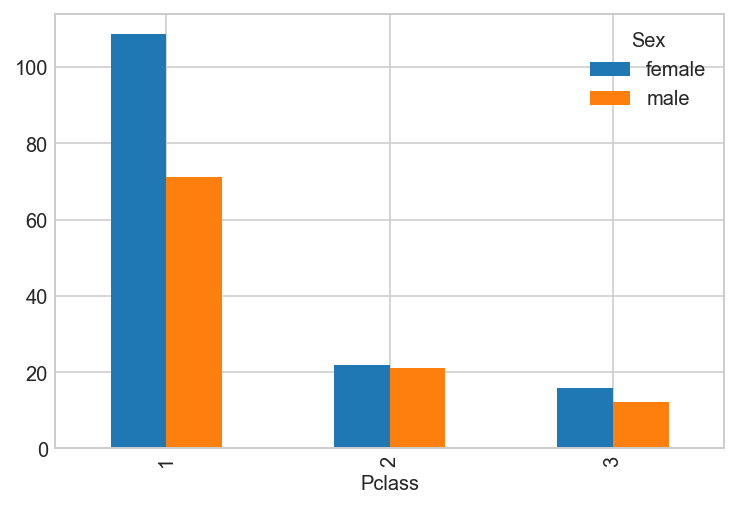

In [198]:
avgfare.unstack().plot(kind='bar')

If you add the keyword variable `stacked=True`, it will instead stack the bars within the broader "Pclass" category.

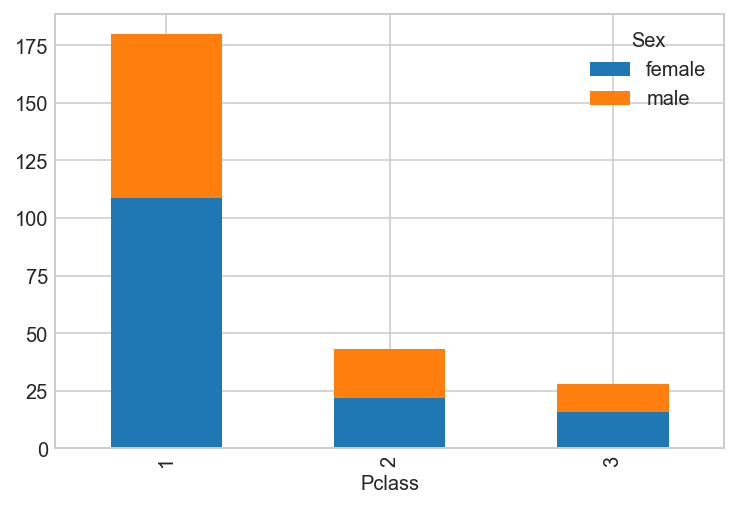

In [199]:
avgfare.unstack().plot(kind='bar', stacked=True)

<a id='independent_practice'></a>

### Independent Practice

---

Now that you've covered the basics of grouping, applying functions, aggregating data, and `pandas` plotting with grouped data, [open up the practice notebook](./practice/practice_pandas_grouping.ipynb)  and explore the UFO sightings data!